In [9]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from collections import Counter

pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

## generate file

## functions 

In [6]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)

def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        class_model = RandomForestClassifier(n_estimators=100,max_features='sqrt').fit(X_train, y_train)
#         y_pred = class_model.predict(X_test)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, class_model.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "rf_rocaoc_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs


## main

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    0.9861     ,    0.9958     ,    1.0000     ,    0.9930     
  0  ,    1.0000     ,    0.9722     ,    0.9916     ,    1.0000     ,    0.9859     
  1  ,    0.9940     ,    1.0000     ,    0.9958     ,    0.9861     ,    0.9930     
  1  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9718     ,    0.9916     ,    1.0000     ,    0.9857     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
  4  ,    0.9760     ,    1.0000     ,    0.9832     ,    0.9467     ,    0.9726     
  4  ,    0.9760     ,    0.9718     ,    0.9748     ,    0.9452     ,    0.9583     
              prec

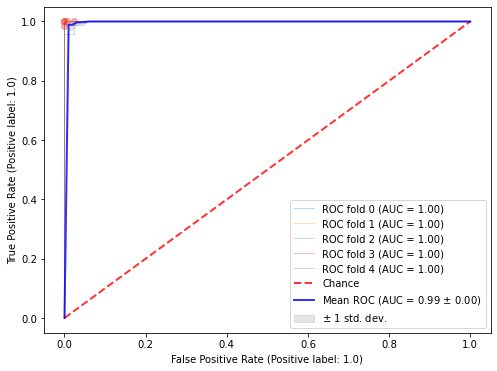

[0.9992930805056554, 0.9999580818242789, 1.0, 1.0, 0.9989879396137303]
0.999647820388733
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9891     ,    1.0000     ,    0.9905     ,    0.9324     ,    0.9650     
  0  ,    0.9956     ,    0.9420     ,    0.9886     ,    0.9701     ,    0.9559     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    0.9956     ,    1.0000     ,    0.9962     ,    0.9718     ,    0.9857     
  2  ,    0.9978     ,    1.0000     ,    0.9981     ,    0.9857     ,    0.9928     
  2  ,    1.0000     ,    0.9710     ,    0.9962     ,    1.0000     ,    0.9853     
  3  ,    0.9978     ,    1.0000     ,    0.9981     ,    0.9857     ,    0.9928     
  3  ,    0.9956     ,    1.0000     ,    0.9962     ,    0.9718     ,    0.9857     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    0.997

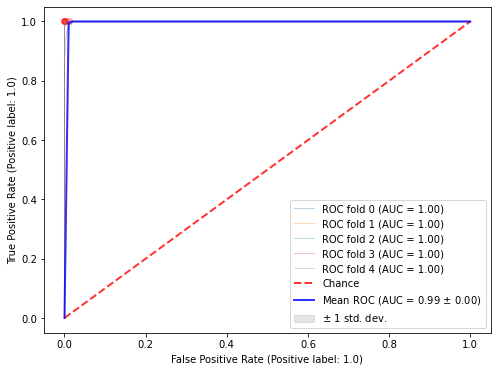

[0.9994316567206593, 1.0, 0.9999684253733699, 0.999984212686685, 1.0]
0.9998768589561429
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9963     ,    0.9948     ,    0.9962     ,    0.9646     ,    0.9795     
  0  ,    0.9974     ,    0.9896     ,    0.9967     ,    0.9744     ,    0.9819     
  1  ,    0.9905     ,    1.0000     ,    0.9914     ,    0.9143     ,    0.9552     
  1  ,    0.9968     ,    0.9792     ,    0.9952     ,    0.9691     ,    0.9741     
  2  ,    0.9926     ,    0.9948     ,    0.9928     ,    0.9317     ,    0.9622     
  2  ,    0.9947     ,    0.9896     ,    0.9943     ,    0.9500     ,    0.9694     
  3  ,    0.9974     ,    0.9948     ,    0.9971     ,    0.9745     ,    0.9845     
  3  ,    0.9974     ,    0.9948     ,    0.9971     ,    0.9745     ,    0.9845     
  4  ,    0.9890     ,    0.9844     ,    0.9885     ,    0.9000     ,    0.9403     
  4  ,    0.996

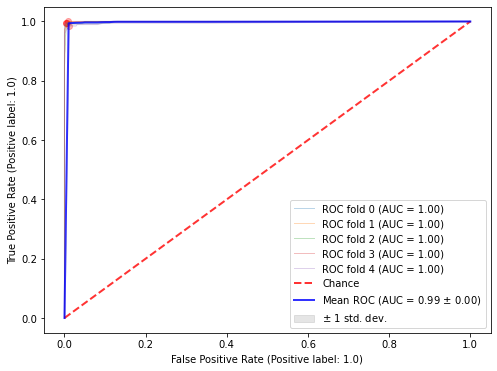

[0.9993612679446778, 0.9997647496498601, 0.9994597448354342, 0.9999152004551821, 0.9957176229866946]
0.9988437171743698
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    0.9991     ,    1.0000     ,    0.9992     ,    0.9904     ,    0.9952     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9991     ,    1.0000     ,    0.9992     ,    0.9904     ,    0.9952     
  3  ,    0.9884     ,    1.0000     ,    0.9893     ,    0.8879     ,    0.9406     
  3  ,    0.9964     ,    0.9903     ,    0.9959     ,    0.9623     ,    0.9761     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,

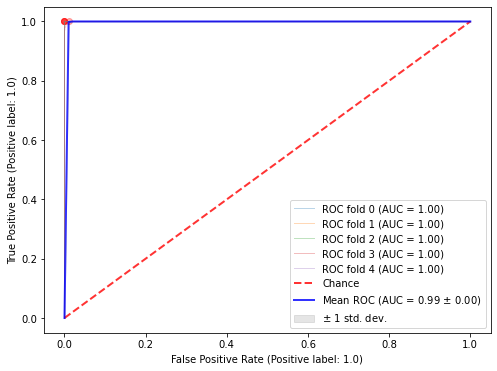

[1.0, 1.0, 1.0, 0.9998477572467551, 1.0]
0.999969551449351
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9825     ,    0.9952     ,    1.0000     ,    0.9912     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,   

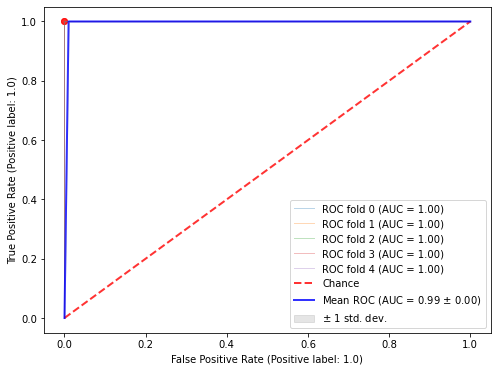

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9950     ,    0.9677     ,    0.9936     ,    0.9091     ,    0.9375     
  0  ,    0.9883     ,    0.9677     ,    0.9873     ,    0.8108     ,    0.8824     
  1  ,    0.9749     ,    1.0000     ,    0.9761     ,    0.6667     ,    0.8000     
  1  ,    0.9983     ,    0.8667     ,    0.9920     ,    0.9630     ,    0.9123     
  2  ,    0.9950     ,    1.0000     ,    0.9952     ,    0.9091     ,    0.9524     
  2  ,    0.9950     ,    1.0000     ,    0.9952     ,    0.9091     ,    0.9524     
  3  ,    0.9933     ,    1.0000     ,    0.9936     ,    0.8824     ,    0.9375     
  3  ,    0.9967     ,    0.9667     ,    0.9952     ,    0.9355     ,    0.9508     
  4  ,    0.9950     ,    0.9667     ,    0.9936     ,    0.9062     ,    0.9355     
  4  ,    0.9933     ,    0.9667     ,    0.9920     ,    0.8788     ,

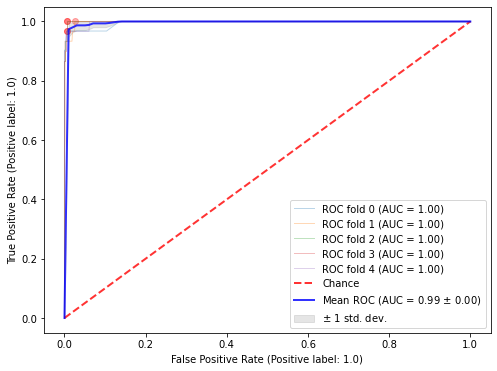

[0.9959003128708599, 0.9979375696767001, 0.9995540691192866, 0.9994983277591973, 0.9977703455964325]
0.9981321250044953
========== Patient_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9660     ,    0.9516     ,    0.9617     ,    0.9219     ,    0.9365     
  0  ,    0.9796     ,    0.8710     ,    0.9474     ,    0.9474     ,    0.9076     
  1  ,    0.9589     ,    0.9677     ,    0.9615     ,    0.9091     ,    0.9375     
  1  ,    0.9795     ,    0.9032     ,    0.9567     ,    0.9492     ,    0.9256     
  2  ,    0.9456     ,    0.9672     ,    0.9519     ,    0.8806     ,    0.9219     
  2  ,    0.9728     ,    0.8525     ,    0.9375     ,    0.9286     ,    0.8889     
  3  ,    0.9184     ,    1.0000     ,    0.9423     ,    0.8356     ,    0.9104     
  3  ,    0.9728     ,    0.8033     ,    0.9231     ,    0.9245     ,    0.8596     
  4  ,    0.9728     ,    0.9836     ,    0.9760     ,    0.9375  

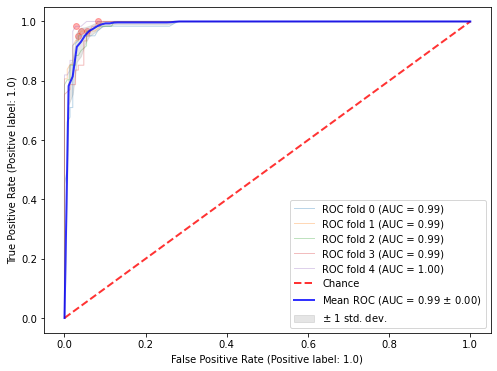

[0.9858459512837393, 0.9939239946973044, 0.991189918590387, 0.9896286383405821, 0.9962083193933311]
0.9913593644610689
========== Patient_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.7500     ,    0.9762     ,    1.0000     ,    0.8571     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    0.9737     ,    1.0000     ,    0.9762     ,    0.8000     ,    0.8889     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000   

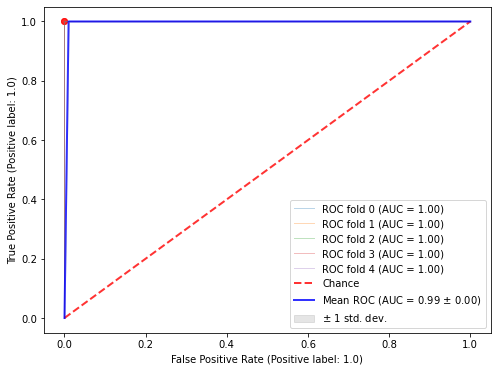

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9981     ,    0.9615     ,    0.9964     ,    0.9615     ,    0.9615     
  0  ,    1.0000     ,    0.8846     ,    0.9945     ,    1.0000     ,    0.9388     
  1  ,    0.9981     ,    1.0000     ,    0.9982     ,    0.9630     ,    0.9811     
  1  ,    0.9981     ,    0.8077     ,    0.9891     ,    0.9545     ,    0.8750     
  2  ,    0.9943     ,    1.0000     ,    0.9945     ,    0.8929     ,    0.9434     
  2  ,    0.9981     ,    0.9200     ,    0.9945     ,    0.9583     ,    0.9388     
  3  ,    0.9733     ,    0.9600     ,    0.9727     ,    0.6316     ,    0.7619     
  3  ,    1.0000     ,    0.8400     ,    0.9927     ,    1.0000     ,    0.9130     
  4  ,    0.9847     ,    1.0000     ,    0.9854     ,    0.7576     ,    0.8621     
  4  ,    1.0000     ,    0.8800     ,    0.9945     ,    1.0000     ,

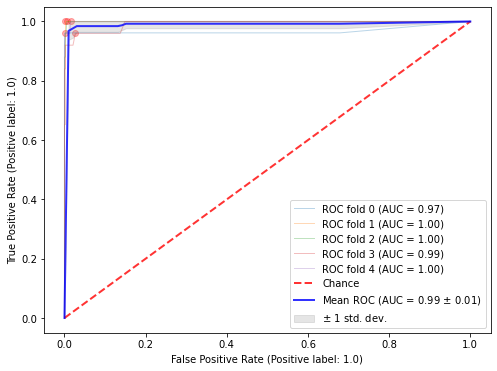

[0.967679070451537, 0.9993381379614649, 0.9996564885496183, 0.9931679389312977, 0.9994274809160306]
0.9918538233619897
========== Patient_6_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9964     ,    0.9778     ,    0.9950     ,    0.9565     ,    0.9670     
  0  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  1  ,    0.9892     ,    1.0000     ,    0.9900     ,    0.8824     ,    0.9375     
  1  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  2  ,    0.9982     ,    1.0000     ,    0.9983     ,    0.9783     ,    0.9890     
  2  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000   

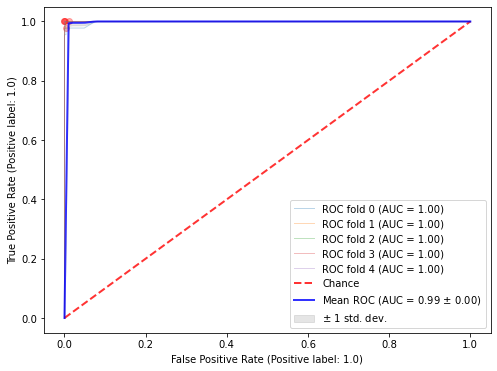

[0.9985385385385386, 0.9997797797797798, 0.9999598876855195, 1.0, 1.0]
0.9996556412007676
========== Patient_7_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9828     ,    0.9913     
  0  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9825     ,    0.9912     
  2  ,    1.0000     ,    0.9821     ,    0.9986     ,    1.0000     ,    0.9910     
  3  ,    0.9954     ,    1.0000     ,    0.9957     ,    0.9492     ,    0.9739     
  3  ,    1.0000     ,    0.9821     ,    0.9986     ,    1.0000     ,    0.9910     
  4  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9825     ,    0.9912     
  4  ,    

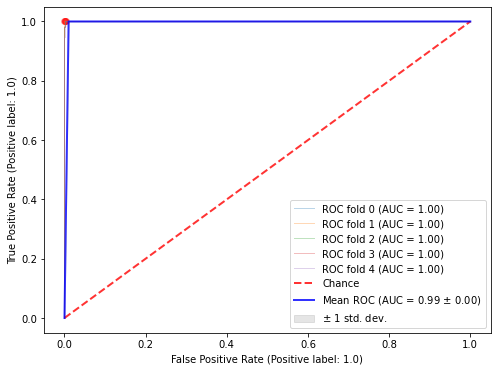

[0.9999729261425168, 1.0, 0.999972442680776, 0.99993110670194, 0.999917328042328]
0.9999587607135121
========== Patient_8_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9766     ,    1.0000     ,    0.9788     ,    0.8182     ,    0.9000     
  0  ,    0.9971     ,    0.9444     ,    0.9921     ,    0.9714     ,    0.9577     
  1  ,    0.9708     ,    1.0000     ,    0.9735     ,    0.7826     ,    0.8780     
  1  ,    0.9942     ,    0.9444     ,    0.9894     ,    0.9444     ,    0.9444     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9971     ,    1.0000     ,    0.9974     ,    0.9730     ,    0.9863     
  3  ,    0.9971     ,    0.9722     ,    0.9947     ,    0.9722     ,    0.9722     
  3  ,    0.9854     ,    0.9722     ,    0.9841     ,    0.8750     ,    0.9211     
  4  ,    0.9971     ,    0.8611     ,    0.9841     ,    0.9688     ,    0.9118     

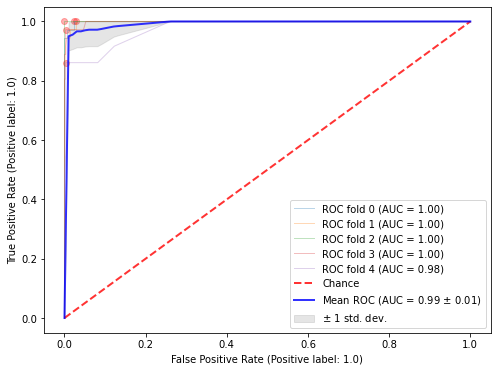

[0.9991877842755036, 0.9983349577647823, 1.0, 0.9983755685510072, 0.9773391812865496]
0.9946474983755687


In [4]:
file_list = [f for f in Path(dect_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample)
    print(aucs)
    print(np.mean(aucs))

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8320     ,    0.6923     ,    0.8253     ,    0.1731     ,    0.2769     
  0  ,    0.9863     ,    0.1538     ,    0.9461     ,    0.3636     ,    0.2162     
  1  ,    0.7734     ,    0.6538     ,    0.7677     ,    0.1278     ,    0.2138     
  1  ,    0.9863     ,    0.1154     ,    0.9442     ,    0.3000     ,    0.1667     
  2  ,    0.6699     ,    0.8077     ,    0.6766     ,    0.1105     ,    0.1944     
  2  ,    0.9805     ,    0.2692     ,    0.9461     ,    0.4118     ,    0.3256     
  3  ,    0.6562     ,    0.8400     ,    0.6648     ,    0.1066     ,    0.1892     
  3  ,    0.9785     ,    0.1600     ,    0.9404     ,    0.2667     ,    0.2000     
  4  ,    0.8105     ,    0.5600     ,    0.7989     ,    0.1261     ,    0.2059     
  4  ,    0.9824     ,    0.2000     ,    0.9460     ,    0.3571     ,    0.2564     
              prec

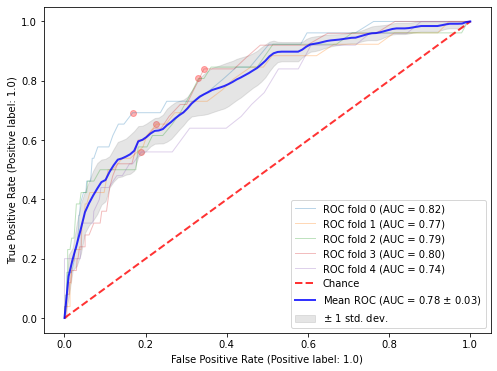

[0.8244441105769231, 0.773212139423077, 0.7947340745192308, 0.795078125, 0.738984375]
0.7852905649038462
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9363     ,    0.9318     ,    0.9360     ,    0.5467     ,    0.6891     
  0  ,    0.9607     ,    0.8182     ,    0.9498     ,    0.6316     ,    0.7129     
  1  ,    0.8668     ,    0.9778     ,    0.8754     ,    0.3826     ,    0.5500     
  1  ,    0.9662     ,    0.6444     ,    0.9412     ,    0.6170     ,    0.6304     
  2  ,    0.9099     ,    0.9778     ,    0.9152     ,    0.4783     ,    0.6423     
  2  ,    0.9625     ,    0.6889     ,    0.9412     ,    0.6078     ,    0.6458     
  3  ,    0.9137     ,    0.8889     ,    0.9118     ,    0.4651     ,    0.6107     
  3  ,    0.9568     ,    0.7556     ,    0.9412     ,    0.5965     ,    0.6667     
  4  ,    0.9043     ,    0.9778     ,    0.9100     ,    0.4632     ,    0.6286     

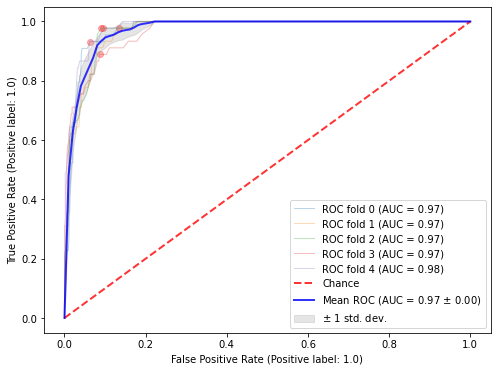

[0.9739955737146748, 0.969522618303106, 0.9717740254325621, 0.9670835939128621, 0.9809255784865542]
0.9726602779699519
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9798     ,    0.8831     ,    0.9752     ,    0.6869     ,    0.7727     
  0  ,    0.9941     ,    0.7792     ,    0.9839     ,    0.8696     ,    0.8219     
  1  ,    0.9551     ,    0.9481     ,    0.9547     ,    0.5141     ,    0.6667     
  1  ,    0.9980     ,    0.7662     ,    0.9870     ,    0.9516     ,    0.8489     
  2  ,    0.9264     ,    0.9091     ,    0.9256     ,    0.3825     ,    0.5385     
  2  ,    0.9941     ,    0.7143     ,    0.9808     ,    0.8594     ,    0.7801     
  3  ,    0.9160     ,    0.9221     ,    0.9163     ,    0.3550     ,    0.5126     
  3  ,    0.9954     ,    0.5974     ,    0.9764     ,    0.8679     ,    0.7077     
  4  ,    0.9277     ,    0.8684     ,    0.9249     ,    0.3729     , 

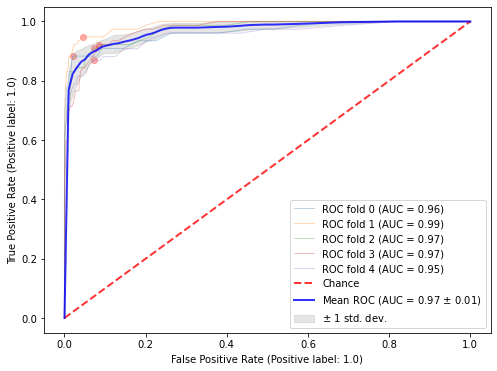

[0.9646535105519481, 0.9892070819805195, 0.9736201298701298, 0.9735482616341992, 0.9545255962171053]
0.9711109160507803
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8730     ,    0.9327     ,    0.8794     ,    0.4709     ,    0.6258     
  0  ,    0.9242     ,    0.8558     ,    0.9168     ,    0.5779     ,    0.6899     
  1  ,    0.8928     ,    0.9327     ,    0.8971     ,    0.5132     ,    0.6621     
  1  ,    0.9359     ,    0.8462     ,    0.9262     ,    0.6154     ,    0.7126     
  2  ,    0.9394     ,    0.7788     ,    0.9220     ,    0.6090     ,    0.6835     
  2  ,    0.9441     ,    0.7500     ,    0.9231     ,    0.6190     ,    0.6783     
  3  ,    0.8705     ,    0.8750     ,    0.8710     ,    0.4505     ,    0.5948     
  3  ,    0.9452     ,    0.7885     ,    0.9282     ,    0.6357     ,    0.7039     
  4  ,    0.9020     ,    0.8654     ,    0.8980     ,    0.5172     ,

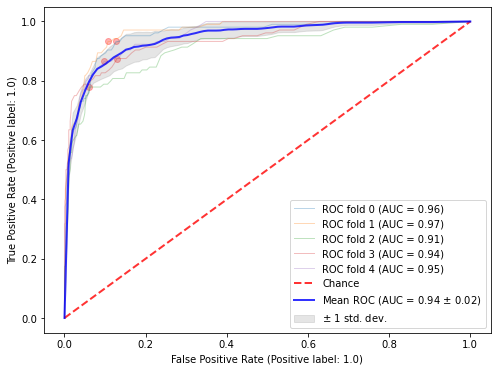

[0.9574536040882194, 0.9663461538461539, 0.9117973372781065, 0.9407705771474734, 0.9541389911139035]
0.9461013326947713
========== Dog_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9417     ,    1.0000     ,    0.9453     ,    0.5333     ,    0.6957     
  0  ,    0.9833     ,    0.8438     ,    0.9746     ,    0.7714     ,    0.8060     
  1  ,    0.9625     ,    1.0000     ,    0.9648     ,    0.6400     ,    0.7805     
  1  ,    0.9917     ,    0.8438     ,    0.9824     ,    0.8710     ,    0.8571     
  2  ,    0.9750     ,    1.0000     ,    0.9766     ,    0.7273     ,    0.8421     
  2  ,    0.9854     ,    0.9375     ,    0.9824     ,    0.8108     ,    0.8696     
  3  ,    0.9938     ,    1.0000     ,    0.9941     ,    0.9143     ,    0.9552     
  3  ,    0.9958     ,    0.9688     ,    0.9941     ,    0.9394     ,    0.9538     
  4  ,    0.9812     ,    1.0000     ,    0.9824     ,    0.7805     ,

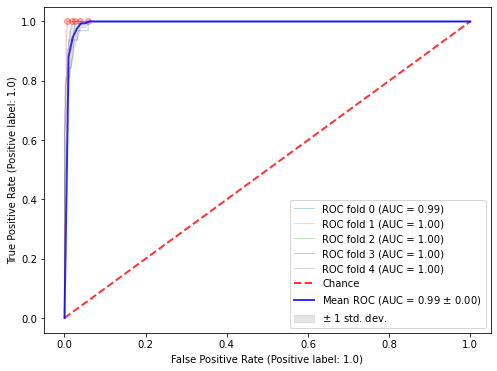

[0.9927408854166666, 0.9952799479166666, 0.9970377604166667, 0.9980794270833333, 0.99775390625]
0.9961783854166667
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  2  ,    0.9818     ,    1.0000     ,    0.9867     ,    0.9524     ,    0.9756     
  2  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     , 

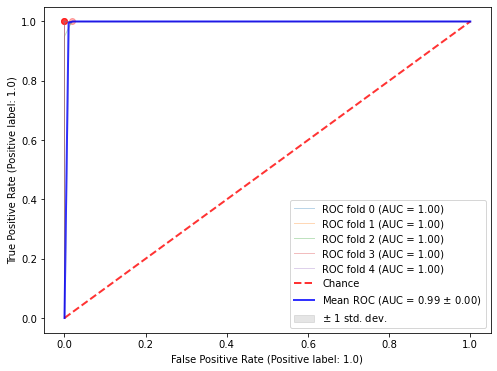

[1.0, 1.0, 0.9995454545454545, 1.0, 1.0]
0.999909090909091
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.8947     ,    0.9697     ,    1.0000     ,    0.9444     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  3  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  3  ,    0.9783     ,    0.9500     ,    0.9697     ,    0.9500     ,    0.9500     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,   

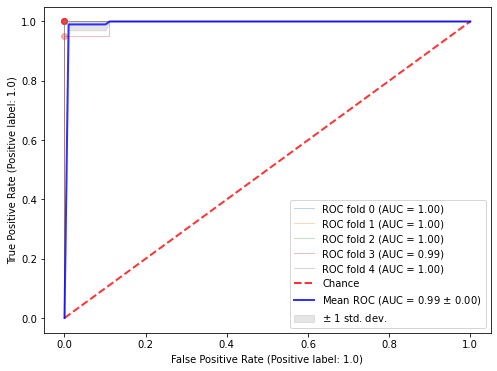

[0.9999999999999999, 1.0, 1.0, 0.9945652173913043, 1.0]
0.9989130434782609


In [11]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample,dop="pred")
    print(aucs)
    print(np.mean(aucs))

# Logistic Regression

In [14]:
def train_pred_lr(X, y, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        class_model = LogisticRegression().fit(X_train, y_train)
#         y_pred = class_model.predict(X_test)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, class_model.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "rf_rocaoc_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs

In [16]:
import warnings
warnings.filterwarnings("ignore")

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.6152     ,    0.8846     ,    0.6283     ,    0.1045     ,    0.1870     
  0  ,    0.7910     ,    0.5385     ,    0.7788     ,    0.1157     ,    0.1905     
  1  ,    0.6836     ,    0.7692     ,    0.6877     ,    0.1099     ,    0.1923     
  1  ,    0.8125     ,    0.4231     ,    0.7937     ,    0.1028     ,    0.1654     
  2  ,    0.7500     ,    0.8077     ,    0.7528     ,    0.1409     ,    0.2400     
  2  ,    0.7754     ,    0.7308     ,    0.7732     ,    0.1418     ,    0.2375     
  3  ,    0.7715     ,    0.6800     ,    0.7672     ,    0.1269     ,    0.2138     
  3  ,    0.8105     ,    0.5600     ,    0.7989     ,    0.1261     ,    0.2059     
  4  ,    0.6582     ,    0.8800     ,    0.6685     ,    0.1117     ,    0.1982     
  4  ,    0.7969     ,    0.4000     ,    0.7784     ,    0.0877     ,    0.1439     
              prec

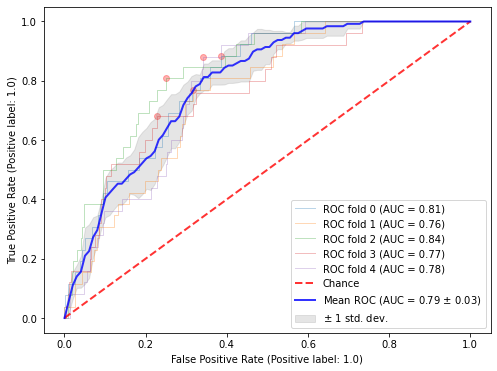

[0.8055889423076923, 0.757361778846154, 0.837890625, 0.771953125, 0.78046875]
0.7906526442307692
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9007     ,    0.8182     ,    0.8945     ,    0.4045     ,    0.5414     
  0  ,    0.8914     ,    0.8182     ,    0.8858     ,    0.3830     ,    0.5217     
  1  ,    0.8762     ,    0.8889     ,    0.8772     ,    0.3774     ,    0.5298     
  1  ,    0.8837     ,    0.8444     ,    0.8806     ,    0.3800     ,    0.5241     
  2  ,    0.8255     ,    0.9333     ,    0.8339     ,    0.3111     ,    0.4667     
  2  ,    0.8687     ,    0.7778     ,    0.8616     ,    0.3333     ,    0.4667     
  3  ,    0.8537     ,    0.8444     ,    0.8529     ,    0.3276     ,    0.4720     
  3  ,    0.8987     ,    0.7778     ,    0.8893     ,    0.3933     ,    0.5224     
  4  ,    0.8874     ,    0.9333     ,    0.8910     ,    0.4118     ,    0.5714     
  4  , 

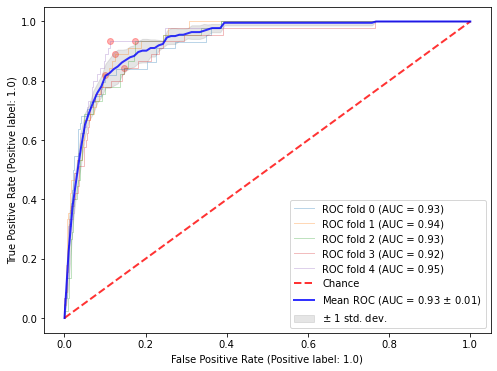

[0.9287538304392235, 0.9426725036481134, 0.9292057535959974, 0.9163643944131749, 0.9465499270377319]
0.9327092818268483
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9538     ,    0.9351     ,    0.9529     ,    0.5035     ,    0.6545     
  0  ,    0.9648     ,    0.8831     ,    0.9609     ,    0.5574     ,    0.6834     
  1  ,    0.9525     ,    0.9091     ,    0.9504     ,    0.4895     ,    0.6364     
  1  ,    0.9701     ,    0.8831     ,    0.9659     ,    0.5965     ,    0.7120     
  2  ,    0.9062     ,    0.8831     ,    0.9051     ,    0.3208     ,    0.4706     
  2  ,    0.9661     ,    0.7792     ,    0.9572     ,    0.5357     ,    0.6349     
  3  ,    0.8561     ,    0.8831     ,    0.8574     ,    0.2353     ,    0.3716     
  3  ,    0.9746     ,    0.7273     ,    0.9628     ,    0.5895     ,    0.6512     
  4  ,    0.8594     ,    0.9342     ,    0.8629     ,    0.2474     ,

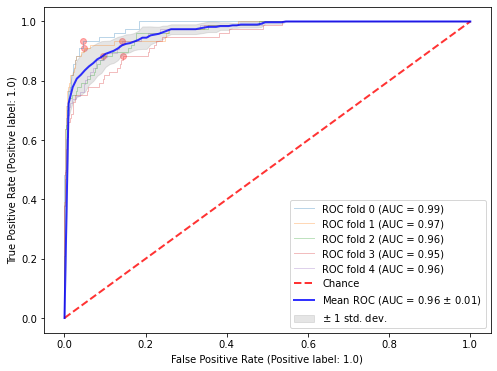

[0.9851021374458875, 0.9736454951298701, 0.9635078463203464, 0.9454900568181818, 0.9639699835526315]
0.9663431038533835
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8077     ,    0.9423     ,    0.8222     ,    0.3726     ,    0.5341     
  0  ,    0.8427     ,    0.8846     ,    0.8472     ,    0.4053     ,    0.5559     
  1  ,    0.8240     ,    0.8846     ,    0.8306     ,    0.3786     ,    0.5303     
  1  ,    0.8578     ,    0.8077     ,    0.8524     ,    0.4078     ,    0.5419     
  2  ,    0.8718     ,    0.8173     ,    0.8659     ,    0.4359     ,    0.5686     
  2  ,    0.8578     ,    0.8173     ,    0.8534     ,    0.4106     ,    0.5466     
  3  ,    0.7585     ,    0.9038     ,    0.7742     ,    0.3123     ,    0.4642     
  3  ,    0.8390     ,    0.7981     ,    0.8345     ,    0.3756     ,    0.5108     
  4  ,    0.7655     ,    0.9327     ,    0.7836     ,    0.3255     ,

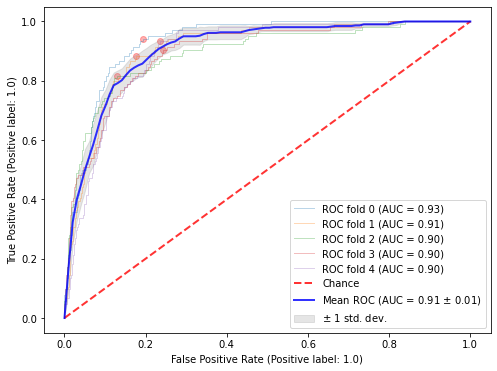

[0.9321767975614129, 0.9084521247982786, 0.8959678142370449, 0.8987747957992999, 0.8991338299973073]
0.9069010724786686
========== Dog_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9688     ,    0.9688     ,    0.9688     ,    0.6739     ,    0.7949     
  0  ,    0.9917     ,    0.9375     ,    0.9883     ,    0.8824     ,    0.9091     
  1  ,    0.9521     ,    0.9375     ,    0.9512     ,    0.5660     ,    0.7059     
  1  ,    0.9854     ,    0.8438     ,    0.9766     ,    0.7941     ,    0.8182     
  2  ,    0.9792     ,    1.0000     ,    0.9805     ,    0.7619     ,    0.8649     
  2  ,    0.9792     ,    0.9375     ,    0.9766     ,    0.7500     ,    0.8333     
  3  ,    0.9896     ,    1.0000     ,    0.9902     ,    0.8649     ,    0.9275     
  3  ,    0.9896     ,    1.0000     ,    0.9902     ,    0.8649     ,    0.9275     
  4  ,    0.9833     ,    1.0000     ,    0.9844     ,    0.8000     ,

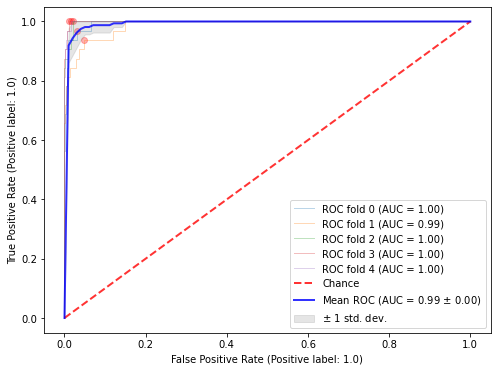

[0.9951822916666667, 0.987109375, 0.9978515625, 0.99921875, 0.9989583333333333]
0.9956640625000001
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    0.9818     ,    1.0000     ,    0.9867     ,    0.9524     ,    0.9756     
  1  ,    0.9818     ,    1.0000     ,    0.9867     ,    0.9524     ,    0.9756     
  1  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  2  ,    0.9818     ,    0.9500     ,    0.9733     ,    0.9500     ,    0.9500     
  2  ,    0.9818     ,    0.9000     ,    0.9600     ,    0.9474     ,    0.9231     
  3  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  3  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  4  ,    1.0000     ,    0.9474     ,    0.9865     ,    1.0000     ,    0.9730     
 

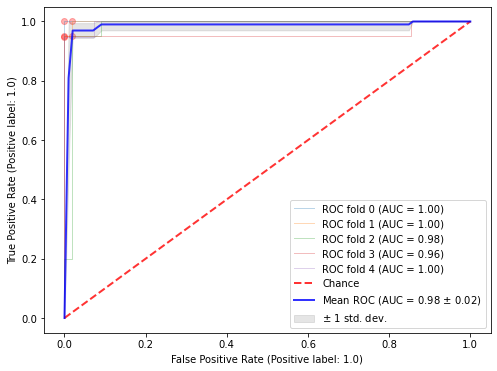

[1.0, 0.999090909090909, 0.9818181818181818, 0.9572727272727273, 0.9961722488038277]
0.9868708133971292
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9574     ,    1.0000     ,    0.9697     ,    0.9048     ,    0.9500     
  0  ,    1.0000     ,    0.8947     ,    0.9697     ,    1.0000     ,    0.9444     
  1  ,    0.9565     ,    1.0000     ,    0.9697     ,    0.9091     ,    0.9524     
  1  ,    0.9783     ,    0.9500     ,    0.9697     ,    0.9500     ,    0.9500     
  2  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  2  ,    1.0000     ,    0.8500     ,    0.9545     ,    1.0000     ,    0.9189     
  3  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  3  ,    0.9783     ,    0.9500     ,    0.9697     ,    0.9500     ,    0.9500     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000  

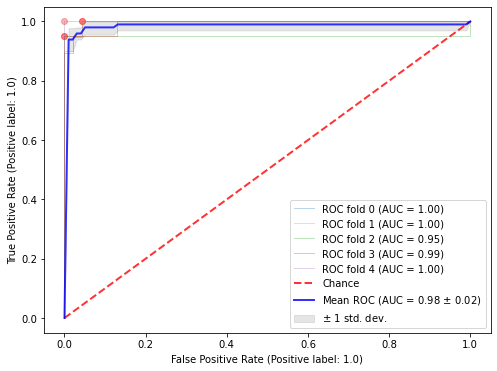

[0.9966405375139978, 0.9967391304347827, 0.95, 0.9934782608695651, 1.0]
0.9873715857636691


In [17]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred_lr(data_x, data_y,save=sample,dop="pred")
    print(aucs)
    print(np.mean(aucs))

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9722     ,    0.9916     ,    1.0000     ,    0.9859     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
              prec

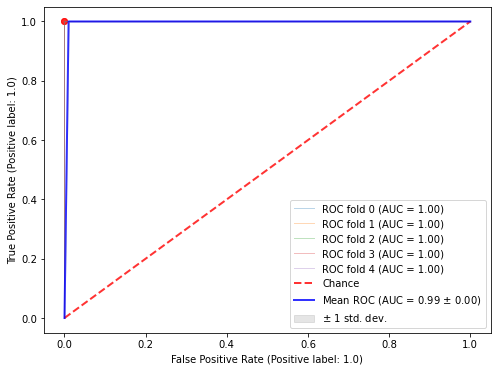

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    0.9913     ,    1.0000     ,    0.9924     ,    0.9452     ,    0.9718     
  1  ,    1.0000     ,    0.9710     ,    0.9962     ,    1.0000     ,    0.9853     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    

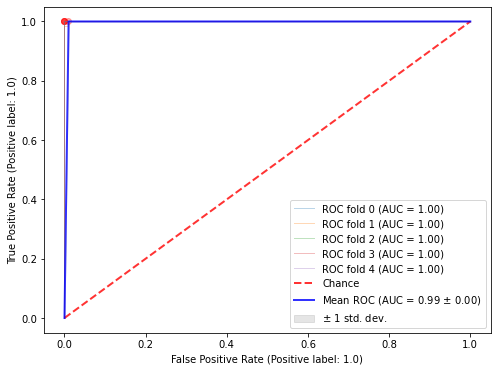

[1.0, 0.9998737014934799, 1.0, 1.0, 1.0]
0.9999747402986958
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9905     ,    0.9948     ,    0.9909     ,    0.9139     ,    0.9526     
  0  ,    0.9926     ,    0.9896     ,    0.9924     ,    0.9314     ,    0.9596     
  1  ,    0.9921     ,    0.9740     ,    0.9905     ,    0.9257     ,    0.9492     
  1  ,    0.9958     ,    0.9635     ,    0.9928     ,    0.9585     ,    0.9610     
  2  ,    0.9905     ,    0.9896     ,    0.9905     ,    0.9135     ,    0.9500     
  2  ,    0.9958     ,    0.9688     ,    0.9933     ,    0.9588     ,    0.9637     
  3  ,    0.9758     ,    0.9896     ,    0.9771     ,    0.8051     ,    0.8879     
  3  ,    0.9968     ,    0.9635     ,    0.9938     ,    0.9686     ,    0.9661     
  4  ,    0.9774     ,    0.9896     ,    0.9785     ,    0.8155     ,    0.8941     
  4  ,    0.9958     ,    0.9635     ,    0.

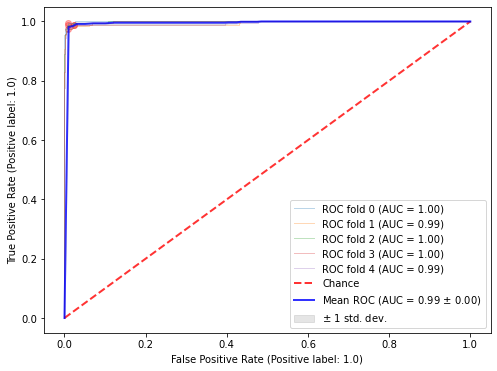

[0.9997127757352942, 0.9948299632352942, 0.9991027661064426, 0.9985173757002801, 0.9948326987044819]
0.9973991158963585
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9812     ,    0.9709     ,    0.9803     ,    0.8264     ,    0.8929     
  0  ,    0.9973     ,    0.9320     ,    0.9918     ,    0.9697     ,    0.9505     
  1  ,    0.9875     ,    0.9612     ,    0.9852     ,    0.8761     ,    0.9167     
  1  ,    0.9919     ,    0.9417     ,    0.9877     ,    0.9151     ,    0.9282     
  2  ,    0.9668     ,    1.0000     ,    0.9696     ,    0.7357     ,    0.8477     
  2  ,    0.9928     ,    0.9612     ,    0.9902     ,    0.9252     ,    0.9429     
  3  ,    0.9964     ,    0.9806     ,    0.9951     ,    0.9619     ,    0.9712     
  3  ,    0.9955     ,    0.9806     ,    0.9943     ,    0.9528     ,    0.9665     
  4  ,    0.9973     ,    0.9608     ,    0.9943     ,    0.9703     ,

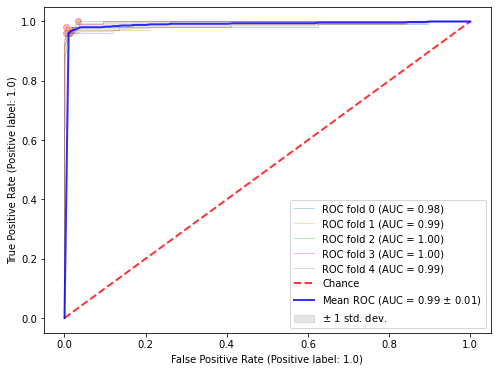

[0.9845234366844138, 0.9852281031422904, 0.9985645683265476, 0.9986515641855448, 0.9932092908848127]
0.9920353926447218
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000  

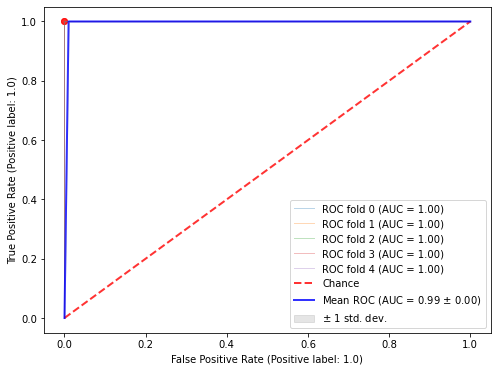

[0.9999999999999999, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9983     ,    0.9355     ,    0.9952     ,    0.9667     ,    0.9508     
  0  ,    0.9933     ,    0.9355     ,    0.9905     ,    0.8788     ,    0.9062     
  1  ,    0.9950     ,    0.9333     ,    0.9920     ,    0.9032     ,    0.9180     
  1  ,    0.9967     ,    0.9000     ,    0.9920     ,    0.9310     ,    0.9153     
  2  ,    0.9849     ,    1.0000     ,    0.9857     ,    0.7692     ,    0.8696     
  2  ,    1.0000     ,    0.9667     ,    0.9984     ,    1.0000     ,    0.9831     
  3  ,    0.9799     ,    1.0000     ,    0.9809     ,    0.7143     ,    0.8333     
  3  ,    0.9900     ,    0.9667     ,    0.9889     ,    0.8286     ,    0.8923     
  4  ,    0.9967     ,    0.9667     ,    0.9952     ,    0.9355     ,    0.9508     
  4  ,    0.9967     ,    0.9333     ,    0.9936     , 

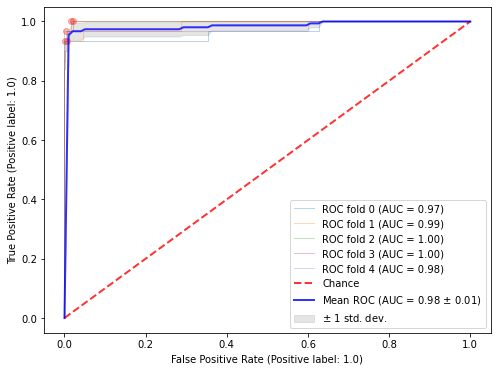

[0.9681734814974646, 0.9887959866220736, 0.9994983277591973, 0.9991638795986622, 0.9797101449275363]
0.9870683640809867
========== Patient_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9796     ,    1.0000     ,    0.9856     ,    0.9538     ,    0.9764     
  0  ,    0.9796     ,    0.9677     ,    0.9761     ,    0.9524     ,    0.9600     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9839     ,    0.9952     ,    1.0000     ,    0.9919     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9672     ,    0.9904     ,    1.0000     ,    0.9833     
  3  ,    1.0000     ,    0.9836     ,    0.9952     ,    1.0000     ,    0.9917     
  3  ,    1.0000     ,    0.9672     ,    0.9904     ,    1.0000     ,    0.9833     
  4  ,    0.9796     ,    0.9836     ,    0.9808     ,    0.9524  

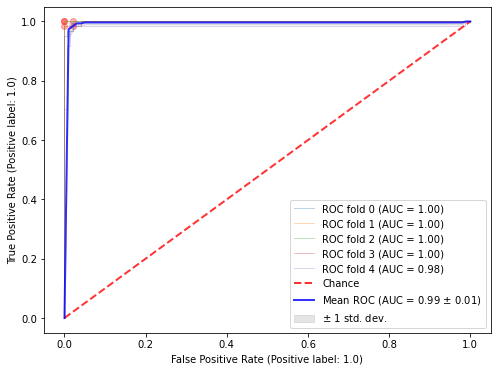

[0.9992319508448542, 1.0, 1.0, 0.9993308798929408, 0.9813761570201852]
0.995987797551596
========== Patient_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1

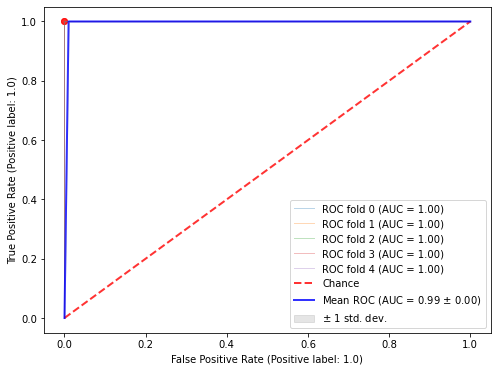

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9615     ,    0.9982     ,    1.0000     ,    0.9804     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    0.9924     ,    1.0000     ,    0.9927     ,    0.8621     ,    0.9259     
  3  ,    0.9981     ,    0.9200     ,    0.9945     ,    0.9583     ,    0.9388     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,

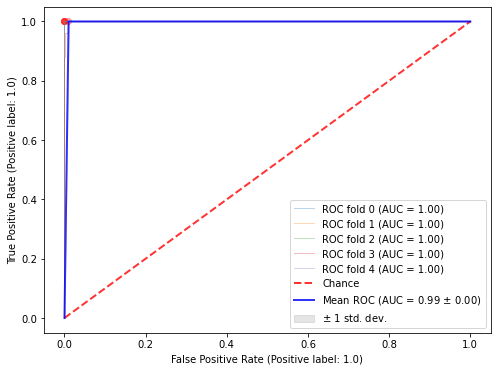

[1.0, 1.0, 1.0, 0.9995419847328244, 1.0]
0.9999083969465647
========== Patient_6_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9964     ,    1.0000     ,    0.9967     ,    0.9574     ,    0.9783     
  0  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9982     ,    1.0000     ,    0.9983     ,    0.9783     ,    0.9890     
  2  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    0.9982     ,    1.0000     ,    0.9983     ,    0.9783     ,    0.9890     
  4  ,    0.9982     ,    1.0000     ,  

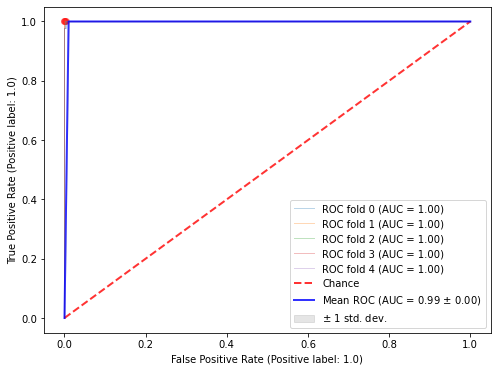

[0.9999199199199199, 1.0, 0.9999598876855194, 1.0, 0.9999598876855195]
0.9999679390581917
========== Patient_7_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9828     ,    0.9913     
  0  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    0.9969     ,    1.0000     ,    0.9972     ,    0.9655     ,    0.9825     
  4  ,    

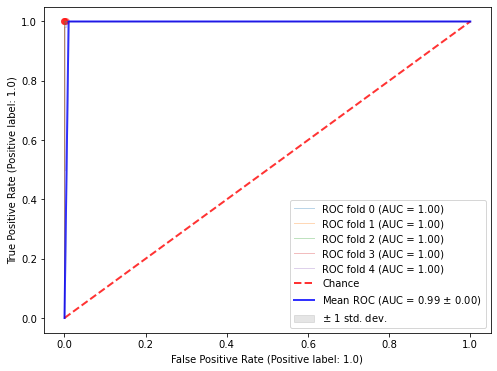

[0.9999729261425168, 1.0, 1.0, 1.0, 0.9992008377425043]
0.9998347527770044
========== Patient_8_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9415     ,    1.0000     ,    0.9471     ,    0.6429     ,    0.7826     
  0  ,    0.9942     ,    0.9167     ,    0.9868     ,    0.9429     ,    0.9296     
  1  ,    0.9883     ,    1.0000     ,    0.9894     ,    0.9000     ,    0.9474     
  1  ,    0.9912     ,    0.9444     ,    0.9868     ,    0.9189     ,    0.9315     
  2  ,    1.0000     ,    0.9722     ,    0.9974     ,    1.0000     ,    0.9859     
  2  ,    0.9942     ,    0.9722     ,    0.9921     ,    0.9459     ,    0.9589     
  3  ,    1.0000     ,    0.9722     ,    0.9974     ,    1.0000     ,    0.9859     
  3  ,    0.9708     ,    0.9722     ,    0.9709     ,    0.7778     ,    0.8642     
  4  ,    0.9942     ,    0.8611     ,    0.9815     ,    0.9394     ,    0.8986     
  4  ,    0.9942     ,   

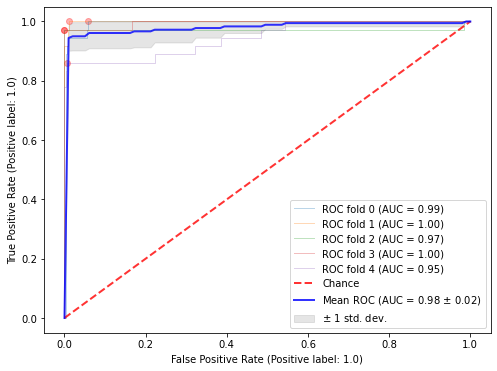

[0.9938271604938271, 0.9991877842755036, 0.9726283300844704, 0.9953703703703705, 0.9452566601689409]
0.9812540610786226


In [18]:
file_list = [f for f in Path(dect_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred_lr(data_x, data_y,save=sample,dop="dect")
    print(aucs)
    print(np.mean(aucs))